In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import re

In [51]:
#Gathering Data Portion
#create full dataframe with all stats
def createWRDF(dfwrA, dfwrB, dfwrnext):
    dfwr = combine(dfwrA, dfwrB)
    dfwr = addNextYrFpts(dfwr, dfwrnext)
    return dfwr

#add fpts/g for next season
def addNextYrFpts(dfwrcurr, dfwrnext):
    dfwrcurr = pd.merge(dfwrcurr, dfwrnext[['Player', 'Fpts/G']], left_on='Player', right_on='Player', how='inner', suffixes=('', '_nextYr'))
    return dfwrcurr

#add advanced stats from fantasy pros
def cleanFP(dfwr):
    dfwr['Player'] = dfwr['Player'].str.split("(").str[0].str.strip()
    dfwr = dfwr.drop(columns=['AIR', 'AIR/R', 'G', 'REC', 'YDS'])
    return dfwr
#add basic stats from pro football reference
def cleanPFR(dfwr):
    dfwr['Player'] = dfwr['Player'].str.replace(re.escape('*'), '', regex=True)
    dfwr['Player'] = dfwr['Player'].str.replace(re.escape('+'), '', regex=True).str.strip()
    dfwr['Fpts/G'] = dfwr.apply(lambda row: (row.Rec + row.Yds / 10 + row.TD * 6 + row.Fmb * - 2) / row.G, axis=1)
    dfwr = dfwr.drop(columns=['Tm', 'Pos', 'Y/R', 'Tgt', 'Lng', 'Rk'])
    return dfwr
#combine advanced and basic stats into one dataframe
def combine(dfwrA, dfwrB):
    dfwrA = cleanFP(dfwrA)
    dfwrB = cleanPFR(dfwrB)
    dfwr = pd.merge(dfwrA, dfwrB, left_on='Player', right_on='Player', how='inner')
    return dfwr

dfwr22A = pd.read_excel(r"C:\Users\luker\Downloads\Python\WR Machine Learning\WR22.xlsx", 'WR22A')
dfwr22B = pd.read_excel(r"C:\Users\luker\Downloads\Python\WR Machine Learning\WR22.xlsx", 'WR22B')
dfwr22 = combine(dfwr22A, dfwr22B)

dfwr21A = pd.read_excel(r"C:\Users\luker\Downloads\Python\WR Machine Learning\WR21.xlsx", 'WR21A')
dfwr21B = pd.read_excel(r"C:\Users\luker\Downloads\Python\WR Machine Learning\WR21.xlsx", 'WR21B')
dfwr21 = createWRDF(dfwr21A, dfwr21B, dfwr22)

<Axes: >

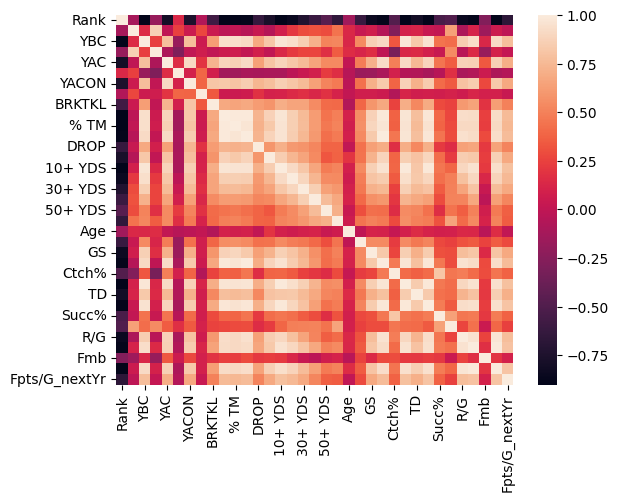

In [52]:
#Data Analysis Portion. Will add to this
corr=dfwr21.corr(numeric_only=True)
sns.heatmap(corr)

0.6483922175787571


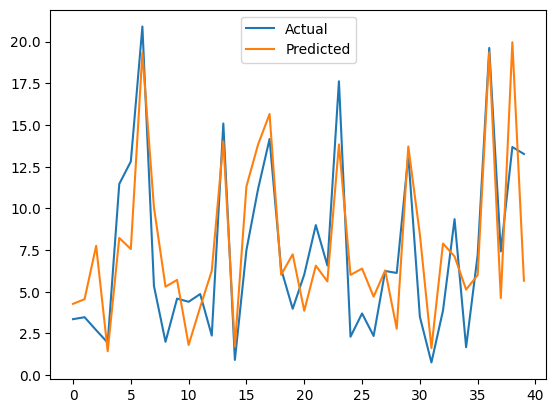

In [82]:
#Machine Learning Portion
X = dfwr21[['Rank', 'Y/R', 'YBC', 'YBC/R', 'YAC', 'YAC/R', 'YACON',
       'YACON/R', 'BRKTKL', 'TGT', '% TM', 'CATCHABLE', 'DROP', 'RZ TGT',
       '10+ YDS', '20+ YDS', '30+ YDS', '40+ YDS', '50+ YDS', 'LNG', 'Age',
       'G', 'GS', 'Rec', 'Ctch%', 'Yds', 'TD', '1D', 'Succ%', 'Y/Tgt', 'R/G',
       'Y/G', 'Fmb', 'Fpts/G']]
y = dfwr21['Fpts/G_nextYr']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=6, shuffle=True, test_size=0.3)

xgb_model = XGBRegressor(max_depth=9, n_estimators=3000, learning_rate=0.005)
xgb_model.fit(X_train, y_train)
y_pred_test = xgb_model.predict(X_test)
xgb_pred_test = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test})
xgb_pred_test = xgb_pred_test.reset_index()
xgb_pred_test = xgb_pred_test.drop(['index'], axis=1)
plt.plot(xgb_pred_test)
plt.legend(['Actual', 'Predicted'])

score = r2_score(y_test, y_pred_test)
print(score)
#64839